In [17]:
#loading essential libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.naive_bayes import GaussianNB
#neural network
from sklearn.neural_network import MLPRegressor

dataset contains only two features so I can consider these as univariate dataset.

In [2]:
scr_df = pd.read_csv('scr-dataset.csv')
scr_df

,x,y
0,1.0,1.750768
1,1.1,1.699704
2,1.2,1.607502
3,1.3,1.479060
4,1.4,1.320438
...,...,...
435,44.5,1.354955
436,44.6,1.523446
437,44.7,1.648505
438,44.8,1.727490


In [3]:
scr_df.isnull().sum().sum()

#no null values

0

<AxesSubplot:xlabel='x', ylabel='y'>

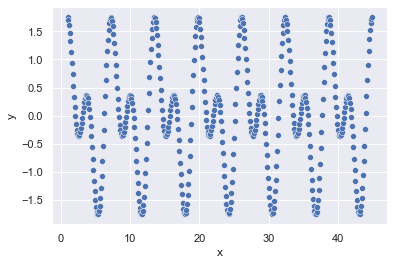

In [4]:
sns.set(style="darkgrid")   
sns.scatterplot(x="x", y="y", data=scr_df)

<AxesSubplot:>

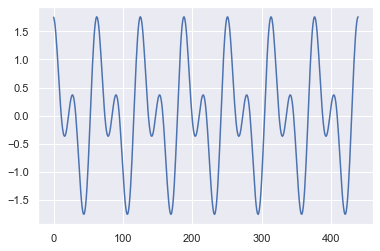

In [6]:
scr_df['y'].plot()

for solving these task I am replacing x with dummy timeseries data since it will be easy to use If we can consider this dataset
as **univariate time-series dataset.**

In [7]:
# create a new dataframe with x = 45 to 50.2 with a step of 0.1 and y = null(this will be used for making predictions)
df_test = pd.DataFrame(columns=['x', 'y'])
df_test['x'] = np.arange(45, 50.2, 0.1)
df_test['y'] = np.nan
# making new column taken_from and fill it with "test"
df_test['taken_from'] = 'test'

In [9]:
# create a new column in df with column name taken_from and fill it with "train"
scr_df['taken_from'] = 'train'

In [10]:
# concatenate df and df_test
df_all = pd.concat([scr_df, df_test])

df_all['x'] = pd.date_range('1/1/2019', periods=493, freq='D')

In [ ]:
df_all.to_csv('src-train&test',index=False)

**loading the saved file**

In [11]:
df = pd.read_csv('src-train&test')
df

,x,y,taken_from
0,2019-01-01,1.750768,train
1,2019-01-02,1.699704,train
2,2019-01-03,1.607502,train
3,2019-01-04,1.479060,train
4,2019-01-05,1.320438,train
...,...,...,...
488,2020-05-03,NaN,test
489,2020-05-04,NaN,test
490,2020-05-05,NaN,test
491,2020-05-06,NaN,test


In [12]:
#converting to time series data 
df['x'] = pd.to_datetime(df['x'])
df = df.set_index('x')

In [13]:
# split the data into train and test
train = df[df['taken_from'] == 'train']
test = df[df['taken_from'] == 'test']

# extract the seasonality data
months = [x.month for x in train.index]
years = [x.year for x in train.index]
day = [x.day for x in train.index]
 
# convert into one matrix
X = np.array([day, months, years]).T

In [14]:
#metrics for evaluting model performance

from sklearn.metrics import mean_absolute_error, mean_squared_error
def MAPE(y, yhat): 
    y, yhat = np.array(y), np.array(yhat)
    try:
        mape =  round(np.mean(np.abs((y - yhat) / y)) * 100,2)
    except:
        print("Observed values are empty")
        mape = np.nan
    return mape

In [15]:
#make predictions on the test data
test_months = [x.month for x in test.index]
test_years = [x.year for x in test.index]
test_day = [x.day for x in test.index]

X_test = np.array([test_day, test_months, test_years]).T

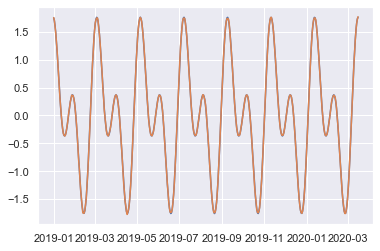

In [24]:
#using xgboost
import xgboost as xgb
 
# fit the model
my_xgb = xgb.XGBRegressor()
my_xgb.fit(X, train.y.values)
 
# predict on the same period
preds = my_xgb.predict(X)
 
# plot what has been learned
plt.plot(train.index, train.y.values)
plt.plot(train.index, preds)

Text(0.5, 1.0, 'XGBOOST')

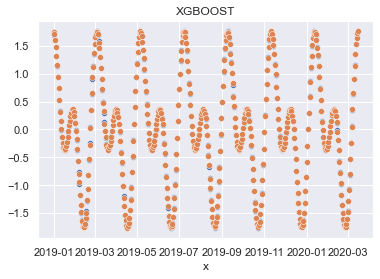

In [44]:
sns.scatterplot(x=train.index, y=train.y.values)
sns.scatterplot(x=train.index, y=preds)
plt.title('XGBOOST')

from above we can see that xgboost fit the data quite well.
Let's see its prediction on test set

In [26]:
#make predictions on the test data
test_months = [x.month for x in test.index]
test_years = [x.year for x in test.index]
test_day = [x.day for x in test.index]

X_test = np.array([test_day, test_months, test_years]).T

# make predictions
xgb_preds_test = my_xgb.predict(X_test)

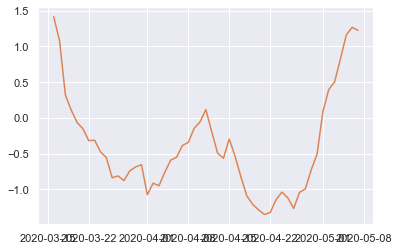

In [27]:
# plot the predictions
plt.plot(test.index, test.y.values)
plt.plot(test.index, xgb_preds_test)

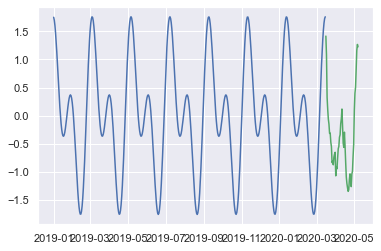

In [28]:
# plot training and test data together
plt.plot(train.index, train.y.values)
plt.plot(test.index, test.y.values)
plt.plot(test.index, xgb_preds_test)

since we see from the above plot that datapoints is following same pattern so we can expect to form the same pattern in future too.. But we can't be fully dependent on the plot so I will be using metrics for evaluting my model performance.

In [30]:
# calculate the above errors with train predictions and train actual values
xgb_train_mape = MAPE(train.y.values, preds)
print("Train MAPE:", xgb_train_mape)
xgb_train_mae=mean_absolute_error(train.y.values, preds)
print("Train MAE:", xgb_train_mae)
xgb_train_mse=mean_squared_error(train.y.values, preds)
print("Train MSE:", xgb_train_mse)

Train MAPE: 4.28
Train MAE: 0.007971203032142306
Train MSE: 0.0001164614931631172


In [31]:
error = pd.DataFrame(columns=['Model', 'MAPE', 'MAE', 'MSE'])
error.loc[0] = ['xgboost', xgb_train_mape, xgb_train_mae, xgb_train_mse]

In [35]:
# use all the models to find the best model
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()
ab = AdaBoostRegressor()
et = ExtraTreesRegressor()
br = BaggingRegressor()
svr = SVR()
lsvr = LinearSVR()
sgd = SGDRegressor()
mlp = MLPRegressor()

# fit the models
rf.fit(X, train.y.values)
gb.fit(X, train.y.values)
ab.fit(X, train.y.values)
et.fit(X, train.y.values)
br.fit(X, train.y.values)
svr.fit(X, train.y.values)
lsvr.fit(X, train.y.values)
sgd.fit(X, train.y.values)
mlp.fit(X, train.y.values)

# make predictions on the train data
rf_preds = rf.predict(X)
gb_preds = gb.predict(X)
ab_preds = ab.predict(X)
et_preds = et.predict(X)
br_preds = br.predict(X)
svr_preds = svr.predict(X)
lsvr_preds = lsvr.predict(X)
sgd_preds = sgd.predict(X)
mlp_preds = mlp.predict(X)

C:\Users\sudee\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\sudee\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


**Lets look at actual value and predicted value with the help of plot**

Text(0.5, 1.0, 'RANDOM FOREST')

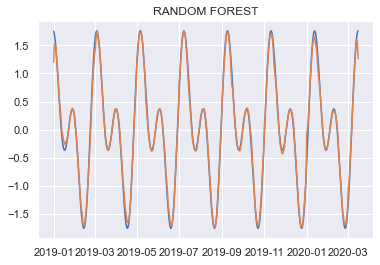

In [36]:
plt.plot(train.index, train.y.values)
plt.plot(train.index, rf_preds)
plt.title('RANDOM FOREST')

Text(0.5, 1.0, 'RANDOM FOREST')

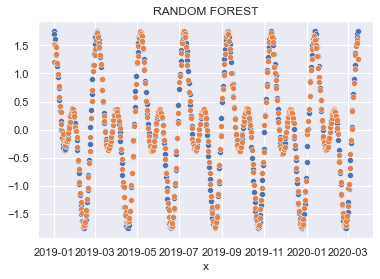

In [39]:
sns.scatterplot(x=train.index, y=train.y.values)
sns.scatterplot(x=train.index, y=rf_preds)
plt.title('RANDOM FOREST')

Text(0.5, 1.0, 'GRADIENT BOOST')

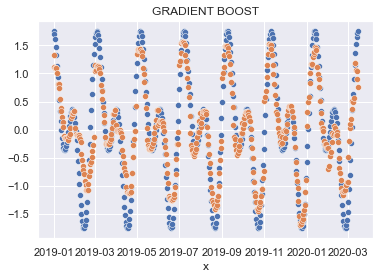

In [40]:
sns.scatterplot(x=train.index, y=train.y.values)
sns.scatterplot(x=train.index, y=gb_preds)
plt.title('GRADIENT BOOST')

Text(0.5, 1.0, 'ADABOOST')

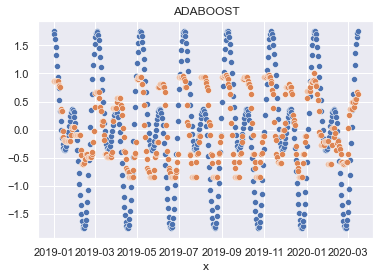

In [41]:
sns.scatterplot(x=train.index, y=train.y.values)
sns.scatterplot(x=train.index, y=ab_preds)
plt.title('ADABOOST')

Text(0.5, 1.0, 'EXTRA TREE REGRESSOR')

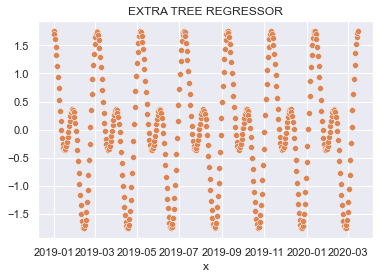

In [42]:
sns.scatterplot(x=train.index, y=train.y.values)
sns.scatterplot(x=train.index, y=et_preds)
plt.title('EXTRA TREE REGRESSOR')

#this seems quite intresting

Text(0.5, 1.0, 'Bagging REGRESSOR')

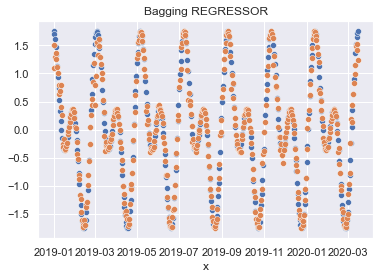

In [43]:
sns.scatterplot(x=train.index, y=train.y.values)
sns.scatterplot(x=train.index, y=br_preds)
plt.title('Bagging REGRESSOR')

Text(0.5, 1.0, 'SUPPORT VECTOR REGRESSOR')

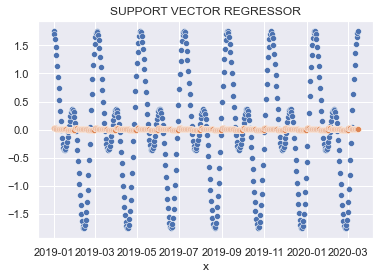

In [45]:
sns.scatterplot(x=train.index, y=train.y.values)
sns.scatterplot(x=train.index, y=svr_preds)
plt.title('SUPPORT VECTOR REGRESSOR')

#it makes worst prediction on train data

Text(0.5, 1.0, 'LINEAR SUPPORT VECTOR REGRESSOR')

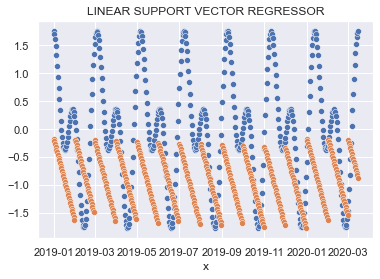

In [46]:
sns.scatterplot(x=train.index, y=train.y.values)
sns.scatterplot(x=train.index, y=lsvr_preds)
plt.title('LINEAR SUPPORT VECTOR REGRESSOR')

Text(0.5, 1.0, 'Stochastic Gradient Descent')

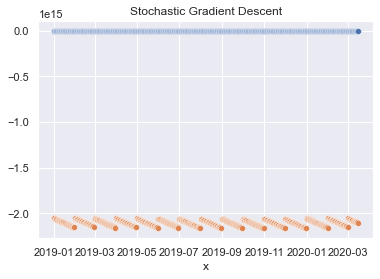

In [47]:
sns.scatterplot(x=train.index, y=train.y.values)
sns.scatterplot(x=train.index, y=sgd_preds)
plt.title('Stochastic Gradient Descent')

Text(0.5, 1.0, 'MULTILAYER PERCEPTRON')

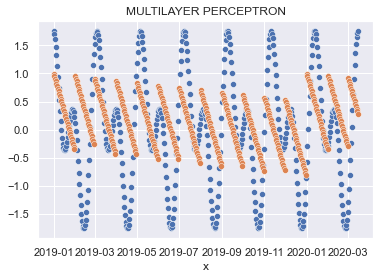

In [48]:
sns.scatterplot(x=train.index, y=train.y.values)
sns.scatterplot(x=train.index, y=mlp_preds)
plt.title('MULTILAYER PERCEPTRON')

**from above plots we can see that some of the model gives worst prediction while model like extra tree regressor predicts very well, but we can't be sure by just plotting the data so now I will be using error metrics to see predicton**

In [49]:
#Random forest
rf_train_mape = MAPE(train.y.values, rf_preds)
rf_train_mae=mean_absolute_error(train.y.values, rf_preds)
rf_train_mse=mean_squared_error(train.y.values, rf_preds)

# gradient boosting
gb_train_mape = MAPE(train.y.values, gb_preds)
gb_train_mae=mean_absolute_error(train.y.values, gb_preds)
gb_train_mse=mean_squared_error(train.y.values, gb_preds)

#ada boost
ab_train_mape = MAPE(train.y.values, ab_preds)
ab_train_mae=mean_absolute_error(train.y.values, ab_preds)
ab_train_mse=mean_squared_error(train.y.values, ab_preds)

#extra tree regressor
et_train_mape = MAPE(train.y.values, et_preds)
et_train_mae=mean_absolute_error(train.y.values, et_preds)
et_train_mse=mean_squared_error(train.y.values, et_preds)

#bagging regressor
br_train_mape = MAPE(train.y.values, br_preds)
br_train_mae=mean_absolute_error(train.y.values, br_preds)
br_train_mse=mean_squared_error(train.y.values, br_preds)

#support vector regressor
svr_train_mape = MAPE(train.y.values, svr_preds)
svr_train_mae=mean_absolute_error(train.y.values, svr_preds)
svr_train_mse=mean_squared_error(train.y.values, svr_preds)

#linear svr
lsvr_train_mape = MAPE(train.y.values, lsvr_preds)
lsvr_train_mae=mean_absolute_error(train.y.values, lsvr_preds)
lsvr_train_mse=mean_squared_error(train.y.values, lsvr_preds)

#sgd
sgd_train_mape = MAPE(train.y.values, sgd_preds)
sgd_train_mae=mean_absolute_error(train.y.values, sgd_preds)
sgd_train_mse=mean_squared_error(train.y.values, sgd_preds)

#mlp
mlp_train_mape = MAPE(train.y.values, mlp_preds)
mlp_train_mae=mean_absolute_error(train.y.values, mlp_preds)
mlp_train_mse=mean_squared_error(train.y.values, mlp_preds)

In [52]:
error.loc[0]

Model     xgboost
MAPE         4.28
MAE      0.007971
MSE      0.000116
Name: 0, dtype: object

In [53]:
error.loc[1] = ['Random Forest',rf_train_mape,rf_train_mae,rf_train_mse]
error.loc[2] = ['Gradient Boosting',gb_train_mape,gb_train_mae,gb_train_mse]
error.loc[3] = ['AdaBoost',ab_train_mape,ab_train_mae,ab_train_mse]
error.loc[4] = ['Extra Tree Regressor',et_train_mape,et_train_mae,et_train_mse]
error.loc[5] = ['Bagging Regressor',br_train_mape,br_train_mae,br_train_mse]
error.loc[6] = ['Support Vector Regressor',svr_train_mape,svr_train_mae,svr_train_mse]
error.loc[7] = ['Linear SVR',lsvr_train_mape,lsvr_train_mae,lsvr_train_mse]
error.loc[8] = ['Stochastic Gradient Descent',sgd_train_mape,sgd_train_mae,sgd_train_mse]
error.loc[9] = ['MULTILAYER PERCEPTRON',mlp_train_mape,mlp_train_mae,mlp_train_mse]

In [57]:
#sort the dataframe with respect to MAE in ascending order
error = error.sort_values(by=['MAE'], ascending=True)

In [58]:
error

,Model,MAPE,MAE,MSE
4,Extra Tree Regressor,0.000000e+00,9.092129e-16,1.738497e-30
0,xgboost,4.280000e+00,7.971203e-03,1.164615e-04
1,Random Forest,3.598000e+01,5.905217e-02,7.454862e-03
5,Bagging Regressor,5.314000e+01,7.201859e-02,1.937440e-02
2,Gradient Boosting,1.325000e+02,2.719297e-01,1.328518e-01
3,AdaBoost,2.829800e+02,6.282518e-01,5.057154e-01
9,MULTILAYER PERCEPTRON,2.892300e+02,7.472738e-01,8.484173e-01
6,Support Vector Regressor,1.008200e+02,7.920389e-01,9.925086e-01
7,Linear SVR,5.375900e+02,1.094789e+00,1.691841e+00
8,Stochastic Gradient Descent,1.244905e+18,2.104530e+15,4.429956e+30


**From above we can clearly see that extra tree regressor scores best**

Now it's time to make prediction on test data

In [60]:
# make predictions on the test data
rf_preds_test = rf.predict(X_test)
gb_preds_test = gb.predict(X_test)
ab_preds_test = ab.predict(X_test)
et_preds_test = et.predict(X_test)
br_preds_test = br.predict(X_test)
svr_preds_test = svr.predict(X_test)
lsvr_preds_test = lsvr.predict(X_test)
sgd_preds_test = sgd.predict(X_test)
mlp_preds_test = mlp.predict(X_test)

Text(0.5, 1.0, 'RANDOM FOREST')

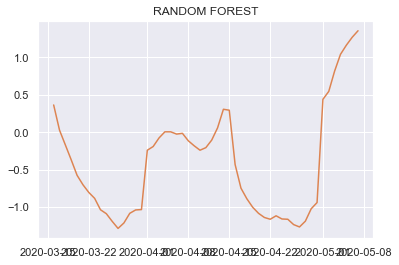

In [65]:
# plot the predictions in different plots
plt.plot(test.index, test.y.values)
plt.plot(test.index, rf_preds_test)
plt.title('RANDOM FOREST')

Text(0.5, 1.0, 'GRADIENT BOOST')

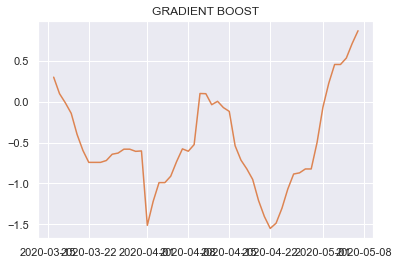

In [66]:
# plot the predictions in different plots
plt.plot(test.index, test.y.values)
plt.plot(test.index, gb_preds_test)
plt.title('GRADIENT BOOST')

Text(0.5, 1.0, 'ADABOOST')

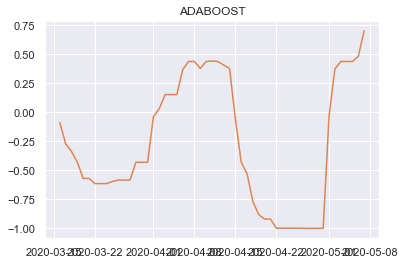

In [67]:
# plot the predictions in different plots
plt.plot(test.index, test.y.values) 
plt.plot(test.index, ab_preds_test)
plt.title('ADABOOST')

Text(0.5, 1.0, 'EXTRAA TREE REG')

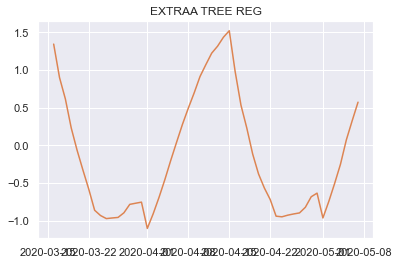

In [68]:
# plot the predictions in different plots
plt.plot(test.index, test.y.values)
plt.plot(test.index, et_preds_test)
plt.title('EXTRAA TREE REG')

Text(0.5, 1.0, 'BOOSTED TREE')

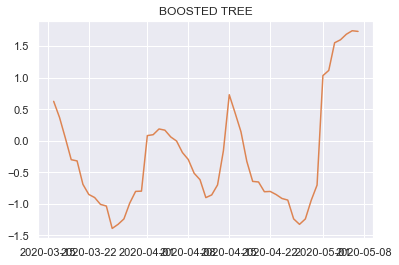

In [69]:
# plot the predictions in different plots
plt.plot(test.index, test.y.values)
plt.plot(test.index, br_preds_test)
plt.title('BOOSTED TREE')

Text(0.5, 1.0, 'SUPPORT VECTOR')

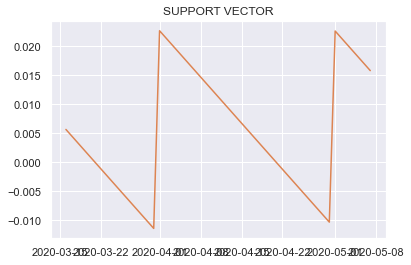

In [70]:
# plot the predictions in different plots
plt.plot(test.index, test.y.values)
plt.plot(test.index, svr_preds_test)
plt.title('SUPPORT VECTOR')

Text(0.5, 1.0, 'LSVR')

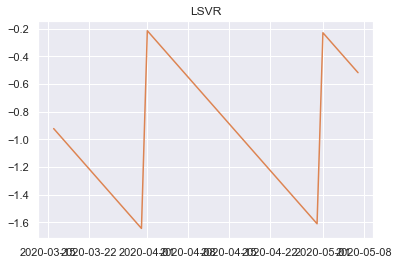

In [71]:
# plot the predictions in different plots
plt.plot(test.index, test.y.values)
plt.plot(test.index, lsvr_preds_test)
plt.title('LSVR')

okay so now we have plotted the test prediction now let's see whether we get the same pattern for both train and test dataset

Text(0.5, 1.0, 'RANDOM FOREST')

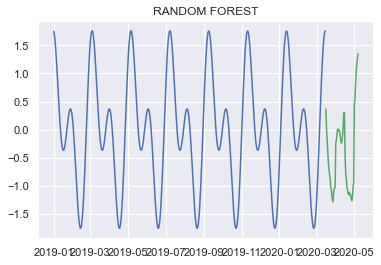

In [81]:
# plot training and test data together
plt.plot(train.index, train.y.values)
plt.plot(test.index, test.y.values)
plt.plot(test.index, rf_preds_test)
plt.title('RANDOM FOREST')

Text(0.5, 1.0, 'GRADIENT BOOST')

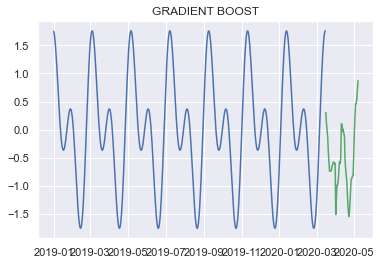

In [82]:
plt.plot(train.index, train.y.values)
plt.plot(test.index, test.y.values)
plt.plot(test.index, gb_preds_test)
plt.title('GRADIENT BOOST')

Text(0.5, 1.0, 'ADABOOST')

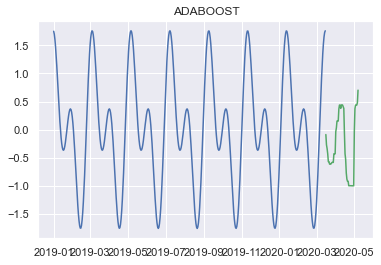

In [83]:
plt.plot(train.index, train.y.values)
plt.plot(test.index, test.y.values)
plt.plot(test.index, ab_preds_test)
plt.title('ADABOOST')

Text(0.5, 1.0, 'EXTRA TREE REG')

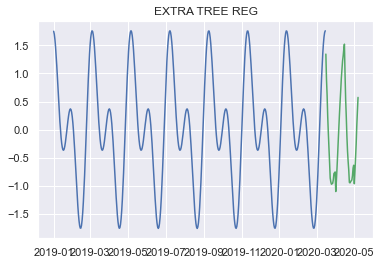

In [84]:
# plot training and test data together
plt.plot(train.index, train.y.values)
plt.plot(test.index, test.y.values)
plt.plot(test.index, et_preds_test)
plt.title('EXTRA TREE REG')

Text(0.5, 1.0, 'BAGGING REG')

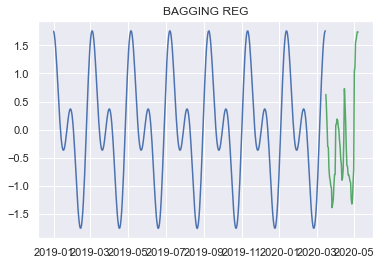

In [85]:
# plot training and test data together
plt.plot(train.index, train.y.values)
plt.plot(test.index, test.y.values)
plt.plot(test.index, br_preds_test)
plt.title('BAGGING REG')

Text(0.5, 1.0, 'SVR')

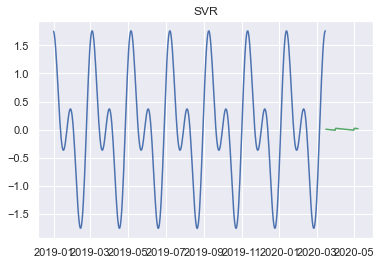

In [86]:
# plot training and test data together
plt.plot(train.index, train.y.values)
plt.plot(test.index, test.y.values)
plt.plot(test.index, svr_preds_test)
plt.title('SVR')

Text(0.5, 1.0, 'LINEAR SVR')

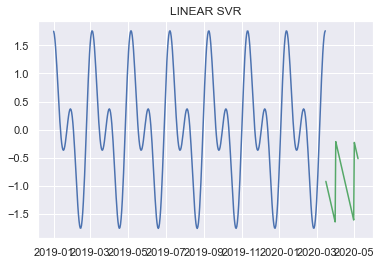

In [87]:
# plot training and test data together
plt.plot(train.index, train.y.values)
plt.plot(test.index, test.y.values)
plt.plot(test.index, lsvr_preds_test)
plt.title('LINEAR SVR')

although Extra tree gives quite good result on train data but it was not able to match the train pattern quite effictvely.

`Lets try last model i.e, Decision tree and see whether it fits the data well?`

In [88]:
dtree = DecisionTreeRegressor()
dtree.fit(X, train.y.values)
dtree_preds = dtree.predict(X)

Text(0.5, 1.0, 'DECISION TREE')

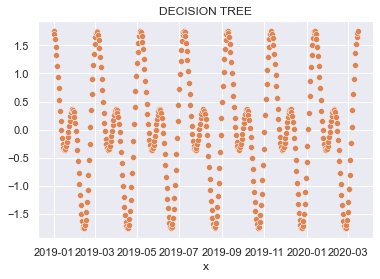

In [89]:
sns.scatterplot(x=train.index, y=train.y.values)
sns.scatterplot(x=train.index, y=dtree_preds)
plt.title('DECISION TREE')

#okay so the model was able to predict train set perfectly

In [90]:
# make predictions
preds_test = dtree.predict(X_test)

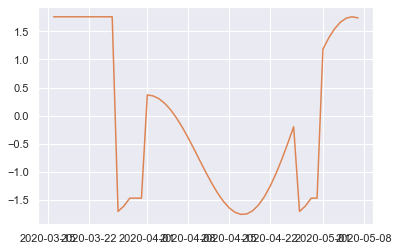

In [91]:
# plot the predictions
plt.plot(test.index, test.y.values)
plt.plot(test.index, preds_test)

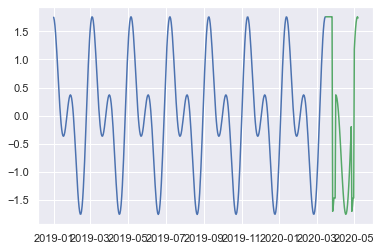

In [92]:
# plot training and test data together
plt.plot(train.index, train.y.values)
plt.plot(test.index, test.y.values)
plt.plot(test.index, preds_test)

*from above we can see that model was able to capture the pattern of train_data*

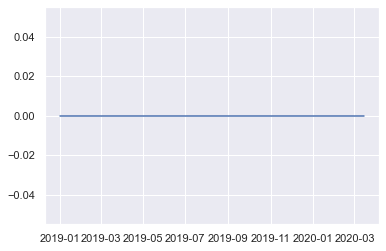

In [93]:
# decision tree residuals
dtree_residuals = train.y.values - dtree_preds
plt.plot(train.index, dtree_residuals)

In [96]:
# calculating error
dtree_train_mape = MAPE(train.y.values, dtree_preds)
dtree_train_mae=mean_absolute_error(train.y.values, dtree_preds)
dtree_train_mse=mean_squared_error(train.y.values, dtree_preds)

In [97]:
error.loc[10] = ['Decision Tree',dtree_train_mape,dtree_train_mae,dtree_train_mse]

In [98]:
#sort the dataframe with respect to MAE in ascending order
error = error.sort_values(by=['MAE'], ascending=True)

In [99]:
error

,Model,MAPE,MAE,MSE
10,Decision Tree,0.000000e+00,0.000000e+00,0.000000e+00
4,Extra Tree Regressor,0.000000e+00,9.092129e-16,1.738497e-30
0,xgboost,4.280000e+00,7.971203e-03,1.164615e-04
1,Random Forest,3.598000e+01,5.905217e-02,7.454862e-03
5,Bagging Regressor,5.314000e+01,7.201859e-02,1.937440e-02
2,Gradient Boosting,1.325000e+02,2.719297e-01,1.328518e-01
3,AdaBoost,2.829800e+02,6.282518e-01,5.057154e-01
9,MULTILAYER PERCEPTRON,2.892300e+02,7.472738e-01,8.484173e-01
6,Support Vector Regressor,1.008200e+02,7.920389e-01,9.925086e-01
7,Linear SVR,5.375900e+02,1.094789e+00,1.691841e+00


**we got error metrics of DECISION TREE equals to 0, which is almost perfect, this might happen because the dataset is relatively simple, we have only one independent feature or it might happen because of very few entries i.e., 440**

**Since my best model was decision tree and also from plot we can see that model captures the pattern quite well, so I will use it as my final model**

In [100]:
# take test predictions from dtee and add that to the test data "y" column
test["y"] = preds_test

<ipython-input-100-29b0a9ba263a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["y"] = preds_test


In [101]:
# add the test predictions to df.y where taken_from=test
df.loc[df.taken_from=="test", "y"] = test.y.values

In [102]:
df

,y,taken_from
x,,
2019-01-01,1.750768,train
2019-01-02,1.699704,train
2019-01-03,1.607502,train
2019-01-04,1.479060,train
2019-01-05,1.320438,train
...,...,...
2020-05-03,1.546359,test
2020-05-04,1.664215,test
2020-05-05,1.735727,test


Text(0.5, 1.0, 'final plot')

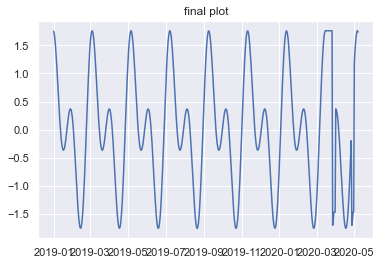

In [105]:
#plot df
plt.plot(df.index, df.y.values)
plt.title('final plot')

In [114]:
df = df.reset_index()

In [116]:
df.loc[df.taken_from=="train", "x"] = scr_df.loc[scr_df.taken_from=="train", "x"]

In [118]:
df.loc[df.taken_from=="test", "x"] = np.arange(45, 50.2, 0.1)

In [120]:
df = df.drop(['taken_from'],axis=1)

In [123]:
df.to_excel("output.xlsx",index=False)

In [126]:
df

,x,y
0,1.0,1.750768
1,1.1,1.699704
2,1.2,1.607502
3,1.3,1.479060
4,1.4,1.320438
...,...,...
488,49.8,1.546359
489,49.9,1.664215
490,50.0,1.735727
491,50.1,1.760160


## from above we can see that the value of y is 1.735727 when x is 50